## Goal 

The goal of this notebook is to develop a model that predicts the player based on features given. 

## Results 

I used word trimming functions in the `Shakespeare_WordTrimming` notebook to get the important words from each PlayerLine. I then used the `textblob` function to assign a sentiment rating for the line (if the line was positive or negative). I then used the Play, Act, Scene, Line and polarity to determine who the player was. The models I used were Decision Trees and Random Forest. They both gave around a 70% accuracy for determing the Player. 

In [16]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from nltk.probability import FreqDist
import nltk
from sklearn.preprocessing import LabelEncoder
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from textblob import TextBlob
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [17]:
data = pd.read_csv('data/PlayerLine_trimmed.csv')

In [18]:
data

,Unnamed: 0,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,3,Henry IV,1.0,1.1.1,KING HENRY IV,"['shaken', 'wan', 'care']"
1,4,Henry IV,1.0,1.1.2,KING HENRY IV,"['find', 'time', 'frighted', 'peace', 'pant']"
2,5,Henry IV,1.0,1.1.3,KING HENRY IV,"['breathe', 'shortwinded', 'accents', 'new', '..."
3,6,Henry IV,1.0,1.1.4,KING HENRY IV,"['commenced', 'strands', 'afar', 'remote']"
4,7,Henry IV,1.0,1.1.5,KING HENRY IV,"['thirsty', 'entrance', 'soil']"
...,...,...,...,...,...,...
104871,111390,A Winters Tale,38.0,5.3.179,LEONTES,"['trothplight', 'daughter', 'good', 'paulina']"
104872,111391,A Winters Tale,38.0,5.3.180,LEONTES,"['lead', 'us', 'hence', 'may', 'leisurely']"
104873,111392,A Winters Tale,38.0,5.3.181,LEONTES,"['one', 'demand', 'answer', 'part']"
104874,111393,A Winters Tale,38.0,5.3.182,LEONTES,"['performd', 'wide', 'gap', 'time', 'since', '..."


Somewhere, the unnamed 0 column was generated. We don't need this. 

In [19]:
del data['Unnamed: 0']

#### Encoding Play and Player

We need to encode the play and player as numbers if we are going to reason about them. I used the LabelEncoder() function to do this. 

In [20]:
le = LabelEncoder()
le.fit(data['Player'])
data['Player'] = le.transform(data['Player'])

In [21]:
le.fit(data['Play'])
data['Play'] = le.transform(data['Play'])
data

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,9,1.0,1.1.1,457,"['shaken', 'wan', 'care']"
1,9,1.0,1.1.2,457,"['find', 'time', 'frighted', 'peace', 'pant']"
2,9,1.0,1.1.3,457,"['breathe', 'shortwinded', 'accents', 'new', '..."
3,9,1.0,1.1.4,457,"['commenced', 'strands', 'afar', 'remote']"
4,9,1.0,1.1.5,457,"['thirsty', 'entrance', 'soil']"
...,...,...,...,...,...
104871,2,38.0,5.3.179,494,"['trothplight', 'daughter', 'good', 'paulina']"
104872,2,38.0,5.3.180,494,"['lead', 'us', 'hence', 'may', 'leisurely']"
104873,2,38.0,5.3.181,494,"['one', 'demand', 'answer', 'part']"
104874,2,38.0,5.3.182,494,"['performd', 'wide', 'gap', 'time', 'since', '..."


#### Seperating Features

Here, I sepearate the ActSceneLine into separate columns for Act Scene Line. Then, in the model, I could reference the act, scene, and line individually.  

In [22]:
data['ActSceneLine'] = data['ActSceneLine'].astype(str)
actsceneline = data.ActSceneLine.str.split(pat='.', n=-1, expand=True)
data['Act'] = actsceneline[0]
data['Scene'] = actsceneline[1]
data['Line'] = actsceneline[2]

del data['ActSceneLine']

data

,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
0,9,1.0,457,"['shaken', 'wan', 'care']",1,1,1
1,9,1.0,457,"['find', 'time', 'frighted', 'peace', 'pant']",1,1,2
2,9,1.0,457,"['breathe', 'shortwinded', 'accents', 'new', '...",1,1,3
3,9,1.0,457,"['commenced', 'strands', 'afar', 'remote']",1,1,4
4,9,1.0,457,"['thirsty', 'entrance', 'soil']",1,1,5
...,...,...,...,...,...,...,...
104871,2,38.0,494,"['trothplight', 'daughter', 'good', 'paulina']",5,3,179
104872,2,38.0,494,"['lead', 'us', 'hence', 'may', 'leisurely']",5,3,180
104873,2,38.0,494,"['one', 'demand', 'answer', 'part']",5,3,181
104874,2,38.0,494,"['performd', 'wide', 'gap', 'time', 'since', '...",5,3,182


#### Turning Text into data 

I used the steps found at : https://sanjayasubedi.com.np/nlp/nlp-feature-extraction/
to binary encode the set of player lines. This assignes number to the words for feature engineering. It's output can be seen in the table below were it appears to use a one-hot encoding to represent which words are used in each line. 

In [23]:
vocab = sorted(set(word for sentence in data['PlayerLine'] for word in sentence.split()))
# print(len(vocab), vocab)

In [24]:
def binary_tranform(text):
    output = np.zeros(len(vocab))
    words = set(text.split())
    for i,v in enumerate(vocab):
        output[i] = v in words
    return output 

In [25]:
vec = CountVectorizer(binary=True)
vec.fit(data['PlayerLine'])
# print([w for w in sorted(vec.vocabulary_.keys())])

CountVectorizer(binary=True)

In [26]:
data_playerLine = pd.DataFrame(vec.transform(data['PlayerLine']).toarray(), columns=sorted(vec.vocabulary_.keys()))
data_playerLine

,10,2d,2s,4d,5s,6d,8d,aaron,aarons,abaissiez,...,zenelophon,zenith,zephyrs,zir,zo,zodiac,zodiacs,zone,zounds,zwaggered
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
fdist = FreqDist(data['PlayerLine'])
fdist.most_common(9)

[('[]', 699),
 ("['lord']", 155),
 ("['sir']", 82),
 ("['know']", 50),
 ("['ay']", 40),
 ("['well']", 39),
 ("['say']", 39),
 ("['madam']", 38),
 ("['whats', 'matter']", 31)]

#### Finding frequency distribution in words 

From the previous encoding, I could then look at the frequency distrubution in the words. 

I took the steps to do this from https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk

In [28]:
from nltk.probability import FreqDist
fdist = FreqDist(data['PlayerLine'])
print(fdist)

<FreqDist with 100157 samples and 104876 outcomes>


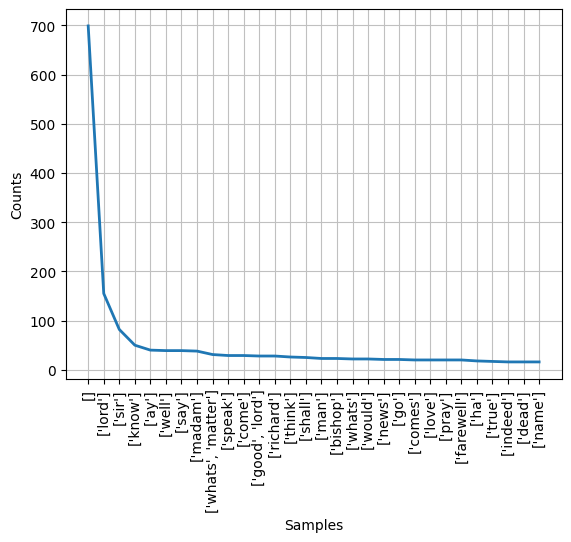

In [29]:
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

### Findings

From this plot, I can see that "lord" and "sir" are the most frequently used words. At one point, I thought there was something I could do with this information, but I couldn't find a way to use it. I tried to use this for feature engineering but it didn't work like I thought. I enjoyed learning about frequency distribution so I kept it in the report.

In [30]:
from nltk import classify
from nltk import NaiveBayesClassifier

### Labeling PlayerLine as positive or negative 

Here, I used `textblob` to determine the polarity of a PlayerLine. The closer to -1 a line is, the more negitive it is. The closer to 1 the polarity is, the more positive the line is. 

In [31]:
data[['polarity', 'subjectivity']] = data['PlayerLine'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [32]:
data

,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line,polarity,subjectivity
0,9,1.0,457,"['shaken', 'wan', 'care']",1,1,1,-0.200000,0.150000
1,9,1.0,457,"['find', 'time', 'frighted', 'peace', 'pant']",1,1,2,0.000000,0.000000
2,9,1.0,457,"['breathe', 'shortwinded', 'accents', 'new', '...",1,1,3,0.136364,0.454545
3,9,1.0,457,"['commenced', 'strands', 'afar', 'remote']",1,1,4,-0.100000,0.200000
4,9,1.0,457,"['thirsty', 'entrance', 'soil']",1,1,5,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
104871,2,38.0,494,"['trothplight', 'daughter', 'good', 'paulina']",5,3,179,0.700000,0.600000
104872,2,38.0,494,"['lead', 'us', 'hence', 'may', 'leisurely']",5,3,180,0.000000,0.000000
104873,2,38.0,494,"['one', 'demand', 'answer', 'part']",5,3,181,0.000000,0.000000
104874,2,38.0,494,"['performd', 'wide', 'gap', 'time', 'since', '...",5,3,182,0.075000,0.366667


# Classification Problem

I decided I wanted to classify the Player based on the Play, Act, Scene, and the polarity of the line. My hope was that we could train a model to recognize that if a line is negative in a certian play, scene, and act, it would likely be from a certain player.

### Random Forest

I found support for creating a Random Forest here: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [33]:
labels = data['Player']
features = data[['Play', 'Act', 'Scene', 'Line','polarity']]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

In [34]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [35]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6882151029748284


### Random Forest, again 

I tried using the random forest again without including the Line in the features. This resulted in much lower accuracy. 

In [36]:
labels = data['Player']
features = data[['Play', 'Act', 'Scene','polarity']]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

In [37]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.41042143401983217


### Decision Trees

Finally, I used the decision tree classification algorithm to fit the data. This resulted in 70% accuracy. 

I found support for creating Decision Tree's in python here: https://www.datacamp.com/community/tutorials/decision-tree-classification-python

In [38]:
labels = data['Player']
features = data[['Play', 'Act', 'Scene', 'Line','polarity']]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

In [39]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7033276125095347


### Final Remarks 

I would love to know what could have made this model more accuarate. I attempted to use the PlayerLine to reason about the Player based on if the line was positive or negative but that didn't work as well as I had hoped. The accuracy of the decision tree and the random forest using polarity as a feature resulted in around 70% accuracy, which is lower than the ideal 90%+ accuracy. 